In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime as dt

In [2]:
today_str = dt.date.today().strftime("%Y_%m_%d")

In [4]:
api_file = open('api.txt')
api_code = "".join(api_file.readlines())

# BEA Regional data (GDP & Personal Income)


# 1. [BEA API](https://apps.bea.gov/api/_pdf/bea_web_service_api_user_guide.pdf)

## 1.1 Find parameters for entire data set

In [5]:
def param_request(method, dataset, param_name, format_type):
    api = api_code
    base = 'http://apps.bea.gov/api/data?&UserID='
    base_api = base+api

    method = '&method='+ method
    data_set = '&datasetname='+ dataset
    param = '&ParameterName='+param_name
    result_format = '&ResultFormat='+ format_type

    final_api = base_api + method + data_set + param + result_format

    request = requests.get(final_api)
    bs = BeautifulSoup(request.text, 'xml')
    
    return bs
    

In [6]:
linecodes = param_request(method = "GetParameterValues", 
                      dataset = 'Regional', 
                      param_name = 'LineCode',
                      format_type = 'XML')

In [7]:
print(linecodes.prettify())

<?xml version="1.0" encoding="utf-8"?>
<BEAAPI>
 <Request>
  <RequestParam ParameterName="USERID" ParameterValue="56CAFC0F-BA67-4159-9CD6-39D7860CA778"/>
  <RequestParam ParameterName="RESULTFORMAT" ParameterValue="XML"/>
  <RequestParam ParameterName="PARAMETERNAME" ParameterValue="LINECODE"/>
  <RequestParam ParameterName="METHOD" ParameterValue="GETPARAMETERVALUES"/>
  <RequestParam ParameterName="DATASETNAME" ParameterValue="REGIONAL"/>
 </Request>
 <Results>
  <ParamValue Desc="[CAGDP1] Real Gross Domestic Product (GDP)" Key="1"/>
  <ParamValue Desc="[CAGDP11] Contributions to percent change in real GDP: All industry total (percent change)" Key="1"/>
  <ParamValue Desc="[CAGDP2] Gross Domestic Product (GDP): All industry total" Key="1"/>
  <ParamValue Desc="[CAGDP8] Chain-type quantity indexes for real GDP: All industry total" Key="1"/>
  <ParamValue Desc="[CAGDP9] Real GDP: All industry total" Key="1"/>
  <ParamValue Desc="[CAINC1] Personal income" Key="1"/>
  <ParamValue Desc="[

## 1.2 Find parameter codes for given table

## GetParameterValuesFiltered

In [8]:
def param_request_filter(method, dataset, param_name, table_name, format_type):
    api = '56CAFC0F-BA67-4159-9CD6-39D7860CA778'
    base = 'http://apps.bea.gov/api/data?&UserID='
    base_api = base+api

    method = '&method='+ method
    
    data_set = '&datasetname='+ dataset
    
    param = '&TargetParameter='+param_name
    
    table = '&TableName=' + table_name 
    
    result_format = '&ResultFormat='+ format_type

    final_api = base_api + method + data_set + param +table + result_format
    request = requests.get(final_api)
    bs = BeautifulSoup(request.text, 'xml')
    
    return bs
    

In [9]:
linecodes_table = param_request_filter(method = "GetParameterValuesFiltered", 
                      dataset = 'Regional', 
                      param_name = 'LineCode', #GEOFIPS
                      table_name = 'SAGDP9N',
                      format_type = 'XML')

In [10]:
print(linecodes_table.prettify())

<?xml version="1.0" encoding="utf-8"?>
<BEAAPI>
 <Request>
  <RequestParam ParameterName="USERID" ParameterValue="56CAFC0F-BA67-4159-9CD6-39D7860CA778"/>
  <RequestParam ParameterName="RESULTFORMAT" ParameterValue="XML"/>
  <RequestParam ParameterName="METHOD" ParameterValue="GETPARAMETERVALUESFILTERED"/>
  <RequestParam ParameterName="DATASETNAME" ParameterValue="REGIONAL"/>
  <RequestParam ParameterName="TABLENAME" ParameterValue="SAGDP9N"/>
  <RequestParam ParameterName="TARGETPARAMETER" ParameterValue="LINECODE"/>
 </Request>
 <Results>
  <ParamValue Desc="[SAGDP9N] Real GDP by state: All industry total" Key="1"/>
  <ParamValue Desc="[SAGDP9N] Real GDP by state: Utilities (NAICS:22)" Key="10"/>
  <ParamValue Desc="[SAGDP9N] Real GDP by state: Construction (NAICS:23)" Key="11"/>
  <ParamValue Desc="[SAGDP9N] Real GDP by state: Manufacturing (NAICS:31-33)" Key="12"/>
  <ParamValue Desc="[SAGDP9N] Real GDP by state: Durable goods manufacturing (NAICS:321,327-339)" Key="13"/>
  <ParamV

### 1.3 Download data

In [11]:
def target_url(method, dataset, table_name, geofips, linecode,  year, format):
    api = '56CAFC0F-BA67-4159-9CD6-39D7860CA778'
    base = 'http://apps.bea.gov/api/data?&UserID='
    base_api = base+api

    method = '&method='+ method
    data_set = '&datasetname='+ dataset
    line_geo_year = '&GeoFIPS='+geofips+'&LineCode='+linecode+'&Year='+year

    table = '&TableName='+ table_name
    result_format = '&ResultFormat='+ format

    final_api = base_api + method + data_set + table + line_geo_year + result_format

    request = requests.get(final_api)
    bs = BeautifulSoup(request.text, 'xml')
    return bs

# 2. Download data

## 2.1 Regional GDP

In [12]:
regional = target_url(method = "GetData", 
                      dataset = 'Regional', 
                      table_name = 'SQGDP9', 
                      geofips = 'STATE', 
                      linecode = '1',
                      year = 'LAST10', 
                      format = 'XML')


## 2.2 Show full data

In [13]:
#print(regional.prettify())

In [14]:
regional.Results.attrs['Statistic']

'Real GDP by state: All industry total'

## 2.3 Only data

In [15]:
for code in regional.find_all('Data'):
    print(code)
    break

<Data CL_UNIT="Millions of chained 2012 dollars" Code="SQGDP9-1" DataValue="15,712,754.0" GeoFips="00000" GeoName="United States" TimePeriod="2011Q1" UNIT_MULT="6"/>


### 2.3.1 Parse data

In [16]:
values, date, state = [],[],[]
for row in regional.find_all('Data'):  
    values.append(row.get('DataValue'))
    date.append(row.get('TimePeriod'))
    state.append(row.get('GeoName'))
data_dict = {'value':values, 'date':date, 'state':state}

## 2.3.2 Convert to dataframe

In [19]:
df = pd.DataFrame.from_dict(data_dict)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   value   2400 non-null   object
 1   date    2400 non-null   object
 2   state   2400 non-null   object
dtypes: object(3)
memory usage: 56.4+ KB


In [20]:
df.head(3)

,value,date,state
0,"15,712,754.0",2011Q1,United States
1,"15,825,096.0",2011Q2,United States
2,"15,820,700.0",2011Q3,United States


### 2.3.2.1 Convert to datatime and float

In [21]:
df.value = [float(x.replace(',','')) for x in df.value]
df.date = [pd.to_datetime(x) for x in df.date]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   value   2400 non-null   float64       
 1   date    2400 non-null   datetime64[ns]
 2   state   2400 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 56.4+ KB
None


In [22]:
df.head(3)

,value,date,state
0,15712754.0,2011-01-01,United States
1,15825096.0,2011-04-01,United States
2,15820700.0,2011-07-01,United States


In [23]:
df.state.value_counts()[:3]

Kentucky         40
West Virginia    40
Arkansas         40
Name: state, dtype: int64

# 3. Download data for each state

## 3.1 Function to download regional data

### 3.1.1 Function

In [24]:
def download_regional_gdp(linecode,  year, col_name):
    api = '56CAFC0F-BA67-4159-9CD6-39D7860CA778'
    base = 'http://apps.bea.gov/api/data?&UserID='
    base_api = base+api

    method = '&method='+ "GetData"
    data_set = '&datasetname='+ 'Regional'
    line_geo_year = '&GeoFIPS='+'STATE'+'&LineCode='+linecode+'&Year='+year

    table = '&TableName='+ 'SQGDP9'
    result_format = '&ResultFormat='+ 'XML'

    final_api = base_api + method + data_set + table + line_geo_year + result_format

    request = requests.get(final_api)
    bs = BeautifulSoup(request.text, 'xml')
    
    data = bs.find_all('Data')

    values, date, state = [],[],[]
    for row in bs.find_all('Data'):  
        values.append(row.get('DataValue'))
        date.append(row.get('TimePeriod'))
        state.append(row.get('GeoName'))
    data_dict = {'value':values, 'date':date, 'state':state}
    
    df = pd.DataFrame.from_dict(data_dict)
    df.value = [x.replace(',','') for x in df.value]
    df.value = pd.to_numeric(df.value, errors='coerce')
    df.date = [pd.to_datetime(x) for x in df.date]
    
    col_rename = 'value_' + col_name
    df.rename(columns={'value':col_rename}, inplace=True)
    
    return df    

### 3.1.2 Test function

In [25]:
df_test = download_regional_gdp('1', 'LAST10', 'Total')
df_test.head(2)

,value_Total,date,state
0,15712754.0,2011-01-01,United States
1,15825096.0,2011-04-01,United States


In [26]:
df_test_2 = download_regional_gdp('6', 'LAST10', 'Mining')
df_test_2.head(2)

,value_Mining,date,state
0,307572.0,2011-01-01,United States
1,310773.0,2011-04-01,United States


In [27]:
df_merge = pd.merge(df_test_2, df_test, on=['state','date'], how='outer')
df_merge.head(2)

,value_Mining,date,state,value_Total
0,307572.0,2011-01-01,United States,15712754.0
1,310773.0,2011-04-01,United States,15825096.0


## 3.3 Download all categories

### 3.3.1 Create dict

In [28]:
code_dict = {
    'Mining':6, 
    'Construction':11,
    'Durable_manu':12,
    'Non_durable_manufact':25,
    'Wholesale':34,
    'Retail':35,
    'Transport':36,
    'Information':45,
    'Real_est':56,
    'Finance':51, #[SAGDP9N] Real GDP by state: Finance and insurance (NAICS:52)
    'Pro_serv':60, #[SAGDP9N] Real GDP by state: Professional, scientific, and technical services (NAICS:54)
    'Edu_serv':69, #SAGDP9N] Real GDP by state: Educational services (NAICS:61)
    'Entertainment':76, #[SAGDP9N] Real GDP by state: Arts, entertainment, and recreation (NAICS:71)
    'Government':83,
    'Other_serv': 82}

### 3.3.2 Download all

In [29]:
df_master = download_regional_gdp('1', 'LAST10', 'Total')
df_master.head(1)

,value_Total,date,state
0,15712754.0,2011-01-01,United States


In [30]:
import time

for name, code in code_dict.items():
    try:
        df_industry = download_regional_gdp(str(code), 'LAST10', str(name))
        df_master = pd.merge(df_master, df_industry, on=['state','date'], how='outer')
    
    except:
        print(name + '-> Does not work')
        pass
    
    time.sleep(5)

### 3.3.3 Sanity check

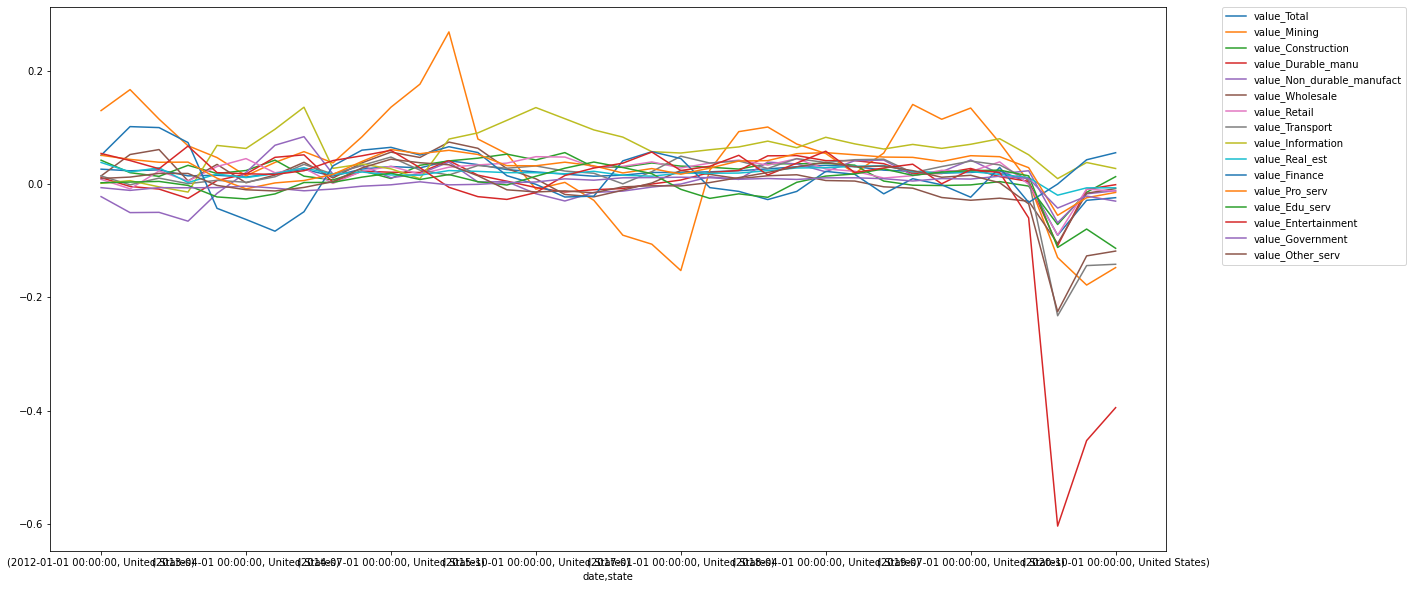

In [31]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

df_master.loc[df_master.state=='United States'].set_index(['date','state']).pct_change(4).dropna().plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### 3.3.4 Export

In [32]:
#file_name = 'Output/regional_gdp_'+today_str
#file_name

In [33]:
#df_master.to_csv(file_name+'.csv')

In [34]:
#df_master.to_excel(file_name+'.xlsx')

# 4. Manipulate data

## 4.A Clean GDP data

In [35]:
df_master_backup = df_master.copy()

In [36]:
df_master_backup.loc[df_master_backup.state == "United States *", ['state']] = 'Total'
df_master_backup.head(1)

,value_Total,date,state,value_Mining,value_Construction,value_Durable_manu,value_Non_durable_manufact,value_Wholesale,value_Retail,value_Transport,value_Information,value_Real_est,value_Finance,value_Pro_serv,value_Edu_serv,value_Entertainment,value_Government,value_Other_serv
0,15712754.0,2011-01-01,United States,307572.0,531719.0,1935305.0,918357.0,964371.0,905036.0,467613.0,757472.0,2005567.0,1080037.0,1119407.0,214086.0,161178.0,2181278.0,343300.0


In [37]:
df_master_backup = df_master_backup.set_index(['date','state'])
cols = list(code_dict.keys())
cols.insert(0,'Total')
df_master_backup.columns = cols
df_master_backup.reset_index(inplace=True)
df_master_backup.head(3)

,date,state,Total,Mining,Construction,Durable_manu,Non_durable_manufact,Wholesale,Retail,Transport,Information,Real_est,Finance,Pro_serv,Edu_serv,Entertainment,Government,Other_serv
0,2011-01-01,United States,15712754.0,307572.0,531719.0,1935305.0,918357.0,964371.0,905036.0,467613.0,757472.0,2005567.0,1080037.0,1119407.0,214086.0,161178.0,2181278.0,343300.0
1,2011-04-01,United States,15825096.0,310773.0,540142.0,1949122.0,923904.0,954387.0,901429.0,472300.0,763612.0,2052272.0,1054571.0,1140278.0,214589.0,163680.0,2181473.0,343279.0
2,2011-07-01,United States,15820700.0,322254.0,540989.0,1925843.0,895564.0,949191.0,893744.0,465990.0,760447.0,2053552.0,1074967.0,1144628.0,212784.0,166115.0,2169941.0,342221.0


## 4.1 Keep only states not regions

### 4.1.1 Download gov names and political affiliation from wikipedia

In [38]:
df_state = pd.read_html('https://en.wikipedia.org/wiki/List_of_current_United_States_governors')[1]
df_state.columns = [''.join(x).split(')')[2] for x in df_state.columns]
df_state.head(2)

,State,Portrait,Governor,Party,Party.1,Born,Prior public experience,Inauguration,End of term,Past governors,Unnamed: 10_level_1
0,Alabama,NaN,Kay Ivey,NaN,Republican,(age 76),"Lieutenant Governor, Treasurer","April 10, 2017",2023,List,NaN
1,Alaska,NaN,Mike Dunleavy,NaN,Republican,(age 60),Alaska Senate,"December 3, 2018",2022,List,NaN


In [39]:
state_list = df_state.State.to_list()
state_list = state_list+['Total']
state_list[:3]

['Alabama', 'Alaska', 'Arizona']

### 4.1.2 isin function to select only rows in state_list

In [40]:
df_master_backup = df_master_backup[df_master_backup.state.isin(state_list)]

In [41]:
len(df_master_backup.state.unique())

50